# Digital Trace Data - Lab 7: Designed Big Data

## Part 1: Enriched Asking

Enriched asking means that you link two datasets together, so crucial here is that you understand the importance of linkage as well as the effects of linkage on the quality of your outcomes. We will follow the notebook by the Coleridge Initative. All code used in this first part of the lab was retrieved from [this notebook](https://mybinder.org/v2/gh/Coleridge-Initiative/bdss-notebooks/master?filepath=04_Record_Linkage.ipynb). If you are interested in diving deeper into the topic, check out their [notebook](https://mybinder.org/v2/gh/Coleridge-Initiative/bdss-notebooks/master?filepath=04_Record_Linkage.ipynb) and their [GitHub repository](https://github.com/Coleridge-Initiative/bdss-notebooks).

### Import of Packages
Python provides us with some tools we can use for record linkages so we don't have to start from scratch and code our own linkage algorithms. So before we start we need to load the package **recordlinkage**. To fully function, this package uses other packages which also need to be imported. Thus we are adding more packages to the ones you are already familiar with.

In [ ]:
!pip install recordlinkage==0.14
!pip install jellyfish==0.9.0

# data manipulation and machine learning
import pandas as pd
import scipy
import sklearn
from sqlite3 import connect

# record linkage package
import recordlinkage as rl
from recordlinkage.preprocessing import clean, phonenumbers, phonetic

### Importing and Connecting to the Database

In [ ]:
!wget https://github.com/Coleridge-Initiative/bdss-notebooks/raw/master/university.db

--2024-10-09 13:04:18--  https://github.com/Coleridge-Initiative/bdss-notebooks/raw/master/university.db
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Coleridge-Initiative/bdss-notebooks/master/university.db [following]
--2024-10-09 13:04:18--  https://raw.githubusercontent.com/Coleridge-Initiative/bdss-notebooks/master/university.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2195456 (2.1M) [application/octet-stream]
Saving to: ‘university.db.2’

university.db.2     100%[===================>]   2.09M  --.-KB/s    in 0.01s   

2024-10-09 13:04:19 (144 MB/s) - ‘university.db.2’ saved [21954

In [ ]:
# to create a connection to the database,
# we need to pass the name of the database

DB = 'university.db'

conn = connect(DB)

### Getting Patents and IPEDS Data

Before we get started on linking two datasets, we need to first bring in our datasets. We'll be linking data from two sources: `uspto_org_location` and `ipeds_location`. We'll do this by bringing in the appropriate tables from the database.

In [ ]:
# Specify the PatentsView data table 'uspto_org_location'

query = '''
SELECT *
FROM uspto
'''
# Read it into a pandas dataframe

uspto_org = pd.read_sql(query,conn)
uspto_org = uspto_org[['assignee_id','assignee_organization','assignee_city','assignee_state']]

In [ ]:
# View the table
uspto_org.head()

,assignee_id,assignee_organization,assignee_city,assignee_state
0,org_tF1qzSsy8BB5p6vsS4Pu,Raytheon Company,Waltham,MA
1,org_aVWnZbQCKaMLmNlCwNfO,Milwaukee Electric Tool Corporation,Brookfield,WI
2,org_FAax03PltNBGM3yj4999,"Alex Toys, LLC",Northvale,NJ
3,org_bWgoxfIzXH6uTL0BVWlZ,Xerox Corporation,Norwalk,CT
4,org_KEkEBZN2iVrf5uObPEOm,"MARKFORGED, INC.",Watertown,MA


#### Question 1.1: Describe what the columns mean in the `uspto` dataset.

*ADD YOUR ANSWER HERE*

In [ ]:
# Load the IPEDS university data

query = '''
SELECT *
FROM ipeds
'''
# Read it into a pandas dataframe

ipeds = pd.read_sql(query,conn)
ipeds = ipeds[['unitid','instnm','city','stabbr']]

In [ ]:
# View the table
ipeds.head()

,unitid,instnm,city,stabbr
0,100654,Alabama A & M University,Normal,AL
1,100663,University of Alabama at Birmingham,Birmingham,AL
2,100690,Amridge University,Montgomery,AL
3,100706,University of Alabama in Huntsville,Huntsville,AL
4,100724,Alabama State University,Montgomery,AL


#### Question 1.2: Describe what the columns mean in the `ipeds` dataset.

*ADD YOUR ANSWER HERE*

#### Question 1.3:	We are now going to use the `clean()` function from the package [`recordlinkage`](https://recordlinkage.readthedocs.io/en/latest/ref-preprocessing.html). Describe in your own words what this function does.

*ADD YOUR ANSWER HERE*

We now use the clean() function to clean the organization names in the uspto dataset.

In [ ]:
# Cleaning names (using the record linkage package tool, see imports)

uspto_org['assignee_organization'] = clean(uspto_org['assignee_organization'])

In [ ]:
uspto_org.head()

,assignee_id,assignee_organization,assignee_city,assignee_state
0,org_tF1qzSsy8BB5p6vsS4Pu,raytheon company,Waltham,MA
1,org_aVWnZbQCKaMLmNlCwNfO,milwaukee electric tool corporation,Brookfield,WI
2,org_FAax03PltNBGM3yj4999,"alex toys, llc",Northvale,NJ
3,org_bWgoxfIzXH6uTL0BVWlZ,xerox corporation,Norwalk,CT
4,org_KEkEBZN2iVrf5uObPEOm,"markforged, inc.",Watertown,MA


In [ ]:
# Concatenate strings by removing white space
uspto_org['assignee_organization'] = uspto_org['assignee_organization'].str.replace(' ','')

In [ ]:
uspto_org.head()

,assignee_id,assignee_organization,assignee_city,assignee_state
0,org_tF1qzSsy8BB5p6vsS4Pu,raytheoncompany,Waltham,MA
1,org_aVWnZbQCKaMLmNlCwNfO,milwaukeeelectrictoolcorporation,Brookfield,WI
2,org_FAax03PltNBGM3yj4999,"alextoys,llc",Northvale,NJ
3,org_bWgoxfIzXH6uTL0BVWlZ,xeroxcorporation,Norwalk,CT
4,org_KEkEBZN2iVrf5uObPEOm,"markforged,inc.",Watertown,MA


#### Question 1.4: How have the names changed?

*ADD YOUR ANSWER HERE*

In [ ]:
uspto_org["phonetic_name"] = phonetic(uspto_org["assignee_organization"], method="nysiis")

In [ ]:
uspto_org.head()

,assignee_id,assignee_organization,assignee_city,assignee_state,phonetic_name
0,org_tF1qzSsy8BB5p6vsS4Pu,raytheoncompany,Waltham,MA,RAYTANCANPANY
1,org_aVWnZbQCKaMLmNlCwNfO,milwaukeeelectrictoolcorporation,Brookfield,WI,MALWACALACTRACTALCARPARATAN
2,org_FAax03PltNBGM3yj4999,"alextoys,llc",Northvale,NJ,"ALAXTAYS,LC"
3,org_bWgoxfIzXH6uTL0BVWlZ,xeroxcorporation,Norwalk,CT,XARAXCARPARATAN
4,org_KEkEBZN2iVrf5uObPEOm,"markforged,inc.",Watertown,MA,"MARCFARGAD,ANC."


#### Question 1.5:	We have now added a column with the function `phonetic`. What does this function do?

*ADD YOUR ANSWER HERE*

Now, we repeat the same steps for the `IPEDS` data:

In [ ]:
ipeds['instnm'] = clean(ipeds['instnm'])

In [ ]:
ipeds['instnm'] = ipeds['instnm'].str.replace(' ','')

In [ ]:
ipeds["phonetic_name"] = phonetic(ipeds['instnm'], method='nysiis')

### Record Linkage

We've done some basic pre-processing of the data, using some of the very useful functions in `recordlinkage.preprocessing`. Now, let's move on to the actual record linkage portion. Though we can dive right in with comparing two names and checking if they match, this process can actually have a lot of nuance to it. For example, you should consider how long this process will take if you have extremely large datasets, with millions and millions of rows to check against millions and millions of rows. In addition, you should consider how strict you want your matching to be. For example, you want to make sure you catch any typos or common misspellings, but want to avoid relaxing the match condition to the point that anything will match with anything.

#### Indexing

Indexing allows you to create candidate links, which basically means identifying pairs of data rows which might refer to the same real world entity. This is also called the comparison space (matrix). There are different ways to index data. The easiest is to create a full index and consider every pair a match. This is also the least efficient method, because we will be comparing every row of one dataset with every row of the other dataset.

If we had 10,000 records in data frame A and 100,000 records in data frame B, we would have 1,000,000,000 candidate links. You can see that comparing over a full index is getting inefficient when working with big data.

We can do better if we actually include our knowledge about the data to eliminate bad link from the start. This can be done through blocking. The `recordlinkage` package gives you multiple options for this. For example, you can block by using variables, which means that only links exactly equal on specified values will be kept.

Here we will block on city and state, to narrow down the number of candidate links.

We need to make sure that the column names that we want to block on are the same in both datasets.

#### Question 1.6: Which columns do we need to rename in both datasets, if we want to link on columns `city` and `state`?

*ADD YOUR ANSWER HERE*

In [ ]:
uspto_org.head()

,assignee_id,assignee_organization,assignee_city,assignee_state,phonetic_name
0,org_tF1qzSsy8BB5p6vsS4Pu,raytheoncompany,Waltham,MA,RAYTANCANPANY
1,org_aVWnZbQCKaMLmNlCwNfO,milwaukeeelectrictoolcorporation,Brookfield,WI,MALWACALACTRACTALCARPARATAN
2,org_FAax03PltNBGM3yj4999,"alextoys,llc",Northvale,NJ,"ALAXTAYS,LC"
3,org_bWgoxfIzXH6uTL0BVWlZ,xeroxcorporation,Norwalk,CT,XARAXCARPARATAN
4,org_KEkEBZN2iVrf5uObPEOm,"markforged,inc.",Watertown,MA,"MARCFARGAD,ANC."


In [ ]:
# Rename the patent dataset columns
uspto_org = uspto_org.rename(columns={'assignee_city':'city'})
uspto_org = uspto_org.rename(columns={'assignee_state':'state'})

In [ ]:
ipeds.head()

,unitid,instnm,city,stabbr,phonetic_name
0,100654,alabamaa&muniversity,Normal,AL,ALABANA&NANAVARSATY
1,100663,universityofalabamaatbirmingham,Birmingham,AL,UNAVARSATYAFALABANATBARNANGAN
2,100690,amridgeuniversity,Montgomery,AL,ANRADGANAVARSATY
3,100706,universityofalabamainhuntsville,Huntsville,AL,UNAVARSATYAFALABANANANTSVAL
4,100724,alabamastateuniversity,Montgomery,AL,ALABANASTATANAVARSATY


In [ ]:
ipeds = ipeds.rename(columns={'stabbr':'state'})

Now we can use the datasets to block. We use the function BlockIndex.

In [ ]:
indexerBL = rl.BlockIndex(on=['city', 'state'])
candidate_links = indexerBL.index(ipeds, uspto_org)

In [ ]:
candidate_links

MultiIndex([(   1,   264),
            (   1,  2484),
            (   1,  2820),
            (   1,  2831),
            (   1,  3906),
            (   1,  7114),
            (   1,  7368),
            (   1,  8182),
            (   1, 10415),
            (   1, 11136),
            ...
            (6855,  2146),
            (6855, 10416),
            (6855, 13247),
            (6855, 13274),
            (6855, 16358),
            (6855, 18542),
            (6856,  3884),
            (6856,  4558),
            (6856, 15843),
            (6856, 17301)],
           length=194256)

#### Question 1.7:	What does this function do? What does the return contain?

*ADD YOUR ANSWER HERE*

Lastly, we will look at the following cells, which is the first match in the list with candidate links.

In [ ]:
ipeds.iloc[1]

,1
unitid,100663
instnm,universityofalabamaatbirmingham
city,Birmingham
state,AL
phonetic_name,UNAVARSATYAFALABANATBARNANGAN


In [ ]:
uspto_org.iloc[264]

,264
assignee_id,org_J1T6dqXm3yFJ9eXQ8ViF
assignee_organization,"altecindustries,inc."
city,Birmingham
state,AL
phonetic_name,"ALTACANDASTRAS,ANC."


#### Question 1.8: What do these cells contain in each dataset? Should this be a match?

*ADD YOUR ANSWER HERE*

#### Record Comparison

In [ ]:
# Initiate compare object
compare_cl = rl.Compare()

In [ ]:
# Initiate compare object
compare_cl = rl.Compare()

compare_cl.string('instnm','assignee_organization', method='jarowinkler', threshold=0.85,label='name')
compare_cl.string('phonetic_name','phonetic_name', method='jarowinkler', threshold=0.85,label='phonetic_name')

<Compare>

In [ ]:
## All attribute comparisons are stored in a DataFrame with horizontally the features and vertically the record pairs.


features = compare_cl.compute(candidate_links, ipeds, uspto_org)

In [ ]:
features.head()

name  phonetic_name
1 264    0.0            0.0
  2484   0.0            0.0
  2820   0.0            0.0
  2831   0.0            0.0
  3906   0.0            0.0

In [ ]:
features[features['name'] == 1]

,,name,phonetic_name
3,8841,1.0,1.0
6,15242,1.0,1.0
10,5112,1.0,1.0
38,5754,1.0,1.0
51,5754,1.0,1.0
...,...,...,...
6465,15225,1.0,1.0
6487,8050,1.0,1.0
6568,18995,1.0,1.0
6652,10323,1.0,1.0


#### Question 1.9: What do we see in the output of the two cells above?

*ADD YOUR ANSWER HERE*

#### Classification

Let's check how many records we get where one or both of comparison attributes match.

In [ ]:
## Simple Classification: Check for how many attributes records are identical by summing the comparison results.
features.sum(axis=1).value_counts().sort_index(ascending=False)

,count
2.0,277
1.0,188
0.0,193791


We can make a decision now, and consider matching all those records which matched on both attributes in our case.

In [ ]:
matches = features[features.sum(axis=1) > 1]  # Filter by those cases which matched on more than 1 attribute
print(len(matches))

277


There are 277 records, which had an exact match on `city` and `state`, and more than 85% in similarity based on university name and the phonetic transcription of the name.

In [ ]:
matches.head()

,,name,phonetic_name
3,8841,1.0,1.0
6,15242,1.0,1.0
10,5112,1.0,1.0
38,5754,1.0,1.0
51,5754,1.0,1.0


Now let's merge these matches back to original dataframes.

Our `matches` dataframe has MultiIndex - two indices to the left which correspond to the `ipeds` table and `uspto_org` table respectively.

We can access each matching pair individually, for example, the first one:

In [ ]:
matches.index[0]

(3, 8841)

We can also do the following: first, pull all the indices for the `ipeds` table.

In [ ]:
matches.index[0][0]

3

We will pull all corresponding rows from the `ipeds` table.

In [ ]:
ipeds_results = []  # Create an empty list

for match in matches.index:  # For every pair in matches (index)
    df = pd.DataFrame(ipeds.loc[[match[0]]])  # Get the location in the original table, convert to dataframe
    ipeds_results.append(df)  # Append to a list

In [ ]:
ipeds_results[0]

,unitid,instnm,city,state,phonetic_name
3,100706,universityofalabamainhuntsville,Huntsville,AL,UNAVARSATYAFALABANANANTSVAL


Now we concatenate the list of dataframes into one dataframe.

In [ ]:
ipeds_concat = pd.concat(ipeds_results)

In [ ]:
ipeds_concat.head()

,unitid,instnm,city,state,phonetic_name
3,100706,universityofalabamainhuntsville,Huntsville,AL,UNAVARSATYAFALABANANANTSVAL
6,100751,theuniversityofalabama,Tuscaloosa,AL,TANAVARSATYAFALABAN
10,100858,auburnuniversity,Auburn,AL,ABARNANAVARSATY
38,101693,universityofmobile,Mobile,AL,UNAVARSATYAFNABAL
51,102094,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN


We do the same for the `uspto` table.

In [ ]:
uspto_results = []  # Create an empty list

for i in matches.index:  # For every pair in matches (index)
    df = pd.DataFrame(uspto_org.loc[[i[1]]])  # Get the location in the original table, convert to dataframe
    uspto_results.append(df)  # Append to a list

uspto_concat = pd.concat(uspto_results)  # Concatenate into one dataframe

In [ ]:
uspto_concat.head()

,assignee_id,assignee_organization,city,state,phonetic_name
8841,org_NxUrG6KS5oqojt99AO9r,universityofalabamainhuntsville,Huntsville,AL,UNAVARSATYAFALABANANANTSVAL
15242,org_5eGSweW3tN2j2AzacuD9,theuniversityofalabama,Tuscaloosa,AL,TANAVARSATYAFALABAN
5112,org_sxNc9S4S8rumMf3sw1MX,auburnuniversity,Auburn,AL,ABARNANAVARSATY
5754,org_4d1VCetVW84oC3rb10vF,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN
5754,org_4d1VCetVW84oC3rb10vF,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN


Now we need to combine two tables on the index - notice that our tables right now have indices from the original tables. We can reset the index using `.reset_index()`.

In [ ]:
ipeds_concat = ipeds_concat.reset_index()

In [ ]:
uspto_concat = uspto_concat.reset_index()

Now our tables have the same index on which we can combine two tables.

In [ ]:
ipeds_concat.head()

,index,unitid,instnm,city,state,phonetic_name
0,3,100706,universityofalabamainhuntsville,Huntsville,AL,UNAVARSATYAFALABANANANTSVAL
1,6,100751,theuniversityofalabama,Tuscaloosa,AL,TANAVARSATYAFALABAN
2,10,100858,auburnuniversity,Auburn,AL,ABARNANAVARSATY
3,38,101693,universityofmobile,Mobile,AL,UNAVARSATYAFNABAL
4,51,102094,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN


In [ ]:
uspto_concat.head()

,index,assignee_id,assignee_organization,city,state,phonetic_name
0,8841,org_NxUrG6KS5oqojt99AO9r,universityofalabamainhuntsville,Huntsville,AL,UNAVARSATYAFALABANANANTSVAL
1,15242,org_5eGSweW3tN2j2AzacuD9,theuniversityofalabama,Tuscaloosa,AL,TANAVARSATYAFALABAN
2,5112,org_sxNc9S4S8rumMf3sw1MX,auburnuniversity,Auburn,AL,ABARNANAVARSATY
3,5754,org_4d1VCetVW84oC3rb10vF,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN
4,5754,org_4d1VCetVW84oC3rb10vF,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN


Now we concatenate these two tables using `.concat()`.

In [ ]:
matched = pd.concat([ipeds_concat,uspto_concat],axis=1)  # Specify axis=1 to concatenate horizontally

In [ ]:
matched.head()

,index,unitid,instnm,city,state,phonetic_name,index,assignee_id,assignee_organization,city,state,phonetic_name
0,3,100706,universityofalabamainhuntsville,Huntsville,AL,UNAVARSATYAFALABANANANTSVAL,8841,org_NxUrG6KS5oqojt99AO9r,universityofalabamainhuntsville,Huntsville,AL,UNAVARSATYAFALABANANANTSVAL
1,6,100751,theuniversityofalabama,Tuscaloosa,AL,TANAVARSATYAFALABAN,15242,org_5eGSweW3tN2j2AzacuD9,theuniversityofalabama,Tuscaloosa,AL,TANAVARSATYAFALABAN
2,10,100858,auburnuniversity,Auburn,AL,ABARNANAVARSATY,5112,org_sxNc9S4S8rumMf3sw1MX,auburnuniversity,Auburn,AL,ABARNANAVARSATY
3,38,101693,universityofmobile,Mobile,AL,UNAVARSATYAFNABAL,5754,org_4d1VCetVW84oC3rb10vF,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN
4,51,102094,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN,5754,org_4d1VCetVW84oC3rb10vF,universityofsouthalabama,Mobile,AL,UNAVARSATYAFSATALABAN


#### Question 1.10: How many records do we have where one or both of the comparison attributes match?

*ADD YOUR ANSWER HERE*

#### Question 1.11: We choose to consider all records with a match on both attributes as matches. Given the processing steps we took, what does this mean substantively?

*ADD YOUR ANSWER HERE*

Question 1.12 How is the resulting matched dataset potentially affected by error?

*ADD YOUR ANSWER HERE*

#### Question 1.13: What is the first item in our matched dataset?

*ADD YOUR ANSWER HERE*

## Part 2: Amplified Asking

In this second part, we will again work with the WhatsApp data, we have already used in week 4.

Here’s a brief recap: Participants from the LISS panel were invited to donate their WhatsApp account data, including data from one of their WhatsApp group chats. They also completed a survey providing details about the number of WhatsApp groups they were part of. For those who agreed to donate their data, we eventually also have access to their actual WhatsApp interactions.

### Question 2.1: In which way can this dataset be compared with the Rwanda dataset from the bit by bit book? In which ways is it different?  

*ADD YOUR ANSWER HERE*

Now, let us first read in the data.

In [ ]:
# Reading in the data
import gdown

# Replace this link with your shared Google Drive link
google_drive_link = "https://drive.google.com/file/d/1Sz0aM__xdv_xmRkomXzIJY2ZrE6nTv7n/view?usp=share_link"

# Extract the file ID from the link
file_id = google_drive_link.split("/")[-2]

# Create the download URL
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
output_file = "downloaded_file"  # specify the desired output file name
gdown.download(download_url, output_file, quiet=False)

# Load downloaded file
import pandas as pd
data = pd.read_csv(output_file)
print(data.head())



Downloading...
From: https://drive.google.com/uc?id=1Sz0aM__xdv_xmRkomXzIJY2ZrE6nTv7n
To: /content/downloaded_file
100%|██████████| 124k/124k [00:00<00:00, 17.6MB/s]

  consent did_donate_account     sex  age education  groups_don  groups_quest
0     yes                Yes    male   46       mbo        39.0          10.0
1      no                 No    male   60        wo         NaN           6.0
2      no                 No    male   72  havo/vwo         NaN           NaN
3      no                 No  female   32       mbo         NaN           1.0
4      no                 No  female   72      vmbo         NaN           NaN


In Week 4, when we already worked with the same data, we found out that the donated data led to higher estimates of the number of groups compared to the survey item. The histogram below plots the number of groups for donated and survey data.

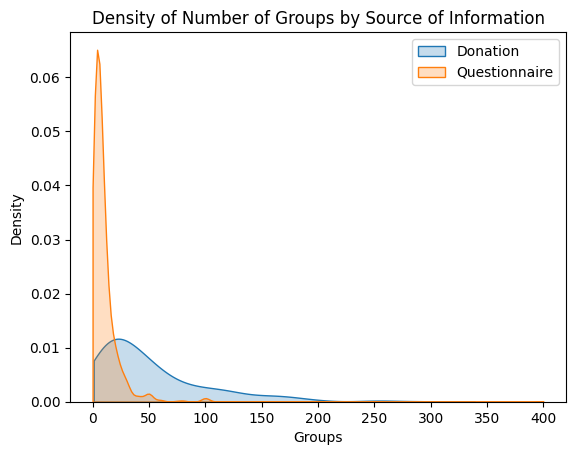

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
sns.kdeplot(data["groups_don"], label = "Donation", fill = True, cut=0)
sns.kdeplot(data["groups_quest"], label = "Questionnaire", fill = True, cut=0)

# Add titles and labels
plt.title("Density of Number of Groups by Source of Information")
plt.xlabel("Groups")
plt.ylabel("Density")
plt.legend()

# Show the plot
plt.show()

What we want to do now, is creating a model to predict the number of WhatsApp groups provided in the donated data using the survey variables as predictors. To do that,	we only take the part where we have observations for both the survey and the donations.

First of all, we need to subset the data to respondents who also donated their WhatsApp data, as we need observations with values in the dependent variable to estimate the model.

In [ ]:
# Subset data to people who donated
data_don = data[data['groups_don'].notna()]

Next, we estimate an OLS regression model to predict *groups_don*. We first only use the self-reported number of groups (i.e., *groups_quest*) as predictor which further illustrates the relationship between the two variables. Next, we include other survey variables, i.e. *sex*, *age*, *education* in the model as well.

In [ ]:
import statsmodels.formula.api as sm

# model only including self-reported groups
model_selfrep = sm.ols(formula="groups_don ~ groups_quest", data=data_don).fit()
print(model_selfrep.summary())

# model including other survey variables
model_full = sm.ols(formula="groups_don ~ sex + age + education + groups_quest", data=data_don).fit()
print(model_full.summary())


                            OLS Regression Results                            
Dep. Variable:             groups_don   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     128.7
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           3.66e-25
Time:                        14:15:13   Log-Likelihood:                -1619.5
No. Observations:                 311   AIC:                             3243.
Df Residuals:                     309   BIC:                             3251.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       36.9725      2.911     12.702   

### Question 2.2: Looking at the model output, which of the two models should we continue with? Reason your decision with a statistic from the output.

*ADD YOUR ANSWER HERE*

Next, we can look at how well the predicted values from the full model for people who donated match with the actual donated values. To do so, we plot them against each other below.

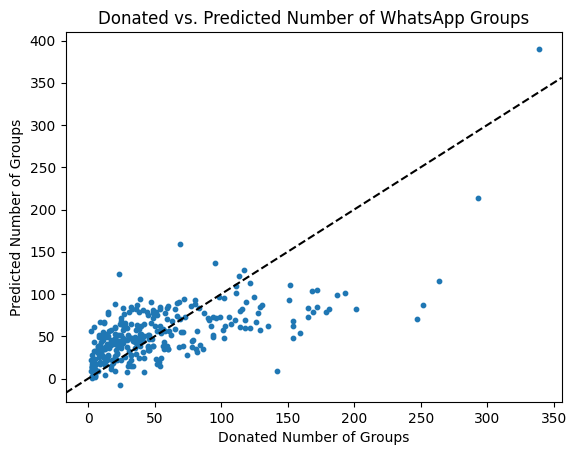

In [ ]:
# Scatter plot donated and predicted data
plt.scatter(data_don["groups_don"], model_full.predict(data_don), s=10)

# Add diagonal dashed line
plt.axline((0, 0), slope=1, color="black", linestyle="--")

# Add titles and labels
plt.xlabel("Donated Number of Groups")
plt.ylabel("Predicted Number of Groups")
plt.title("Donated vs. Predicted Number of WhatsApp Groups")

# Show the plot
plt.show()


Additionally we can again look at the densities

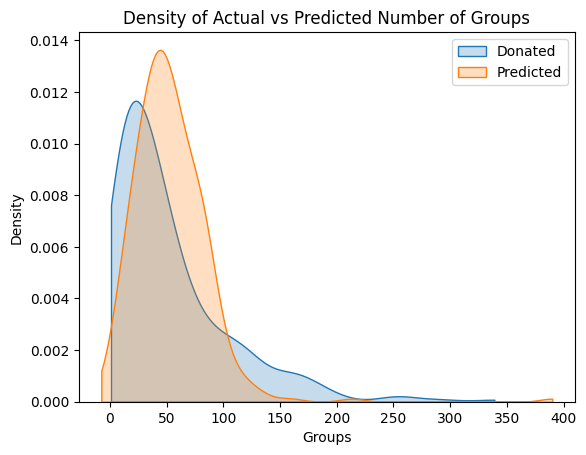

In [ ]:
# Plot densities
sns.kdeplot(data_don["groups_don"], label = "Donated", fill = True, cut=0)
sns.kdeplot(model_full.predict(data_don), label = "Predicted", fill = True, cut=0)

# Add titles and labels
plt.title("Density of Actual vs Predicted Number of Groups")
plt.xlabel("Groups")
plt.ylabel("Density")
plt.legend()

# Show the plot
plt.show()


### Question 2.3: Inspecting the two plots above, what do you notice about the predicted values? Does the model predict the number of groups well?

*ADD YOUR ANSWER HERE*

We can now run a cross-validation:

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Only keep complete observations (listwise deletion)
X = data_don[["sex", "age", "education", "groups_quest"]].dropna()
y = data_don["groups_don"][X.index]

# Create label encoder for the categorical variables
le = LabelEncoder()

# Fit and transform the categorical variables
X["sex"] = le.fit_transform(X["sex"]) # convert sex to numeric values
X["education"] = le.fit_transform(X["education"]) # convert education to numeric values

# Estimate linear model
model = LinearRegression()

# Perform cross-validation
r2_scores = cross_val_score(model, X, y, cv=5, scoring= "r2")

# Retrieve r2 values per fold
print("R2 scores:", r2_scores)
print("Average R2 score:", r2_scores.mean())



R2 scores: [0.17839802 0.18656432 0.02879055 0.39972704 0.39857481]
Average R2 score: 0.23841094846299066


And then use the estimated model to predict the number of groups for participants who did not donate their Whatsapp groups.

In [ ]:
# Subset to people who have values for all survey variables & didn't donate
data_survey = data[data['groups_don'].isna() & data[['sex', 'age', 'education', 'groups_quest']].notna().all(axis=1)]

# Select predictor variables
X_new = data_survey[["sex", "age", "education", "groups_quest"]]

# Fit and transform the categorical variables
X_new["sex"] = le.fit_transform(X_new["sex"])
X_new["education"] = le.fit_transform(X_new["education"])

# Estimate linear model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X_new)

# Add predictions to the data_survey
data_survey['groups_don_pred'] = y_pred

print(data_survey.head())

  consent did_donate_account     sex  age education  groups_don  groups_quest  \
1      no                 No    male   60        wo         NaN           6.0   
3      no                 No  female   32       mbo         NaN           1.0   
5     yes                 No  female   39       mbo         NaN          10.0   
6      no                 No  female   69       mbo         NaN           2.0   
7      no                 No  female   48       mbo         NaN           4.0   

   groups_don_pred  
1        38.083152  
3        42.462145  
5        43.099031  
6         6.960046  
7        29.252777  


<ipython-input-63-071224680c1c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new["sex"] = le.fit_transform(X_new["sex"])
<ipython-input-63-071224680c1c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new["education"] = le.fit_transform(X_new["education"])
<ipython-input-63-071224680c1c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

Lastly, we can compare the distribution of Whatsapp groups of the actual data from the donation and the predictions from our model:

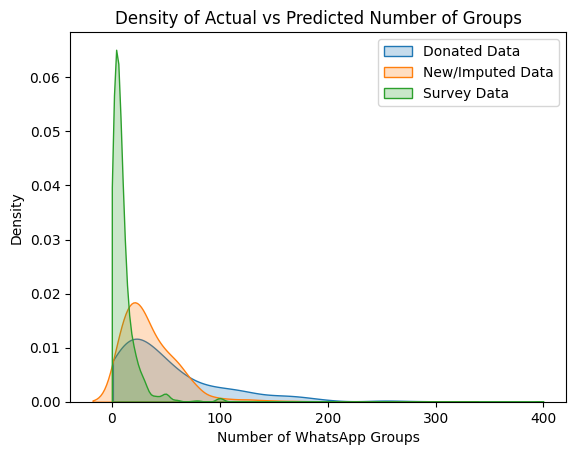

In [ ]:
# concatenate data_don["groups_don"] and data_survey['groups_don_pred']
data_all = pd.concat([data_don["groups_don"], data_survey['groups_don_pred']])

# density plot for actual donated values
sns.kdeplot(data_don["groups_don"], label="Donated Data", fill = True, cut=0)

# density plot for predicted donated values
sns.kdeplot(data_all, label="New/Imputed Data", fill = True, cut=0)

# density plot for the survey group
sns.kdeplot(data["groups_quest"], label="Survey Data", fill = True, cut=0)

# Add titles and labels
plt.title("Density of Actual vs Predicted Number of Groups")

plt.xlabel("Number of WhatsApp Groups")
plt.ylabel("Density")
plt.legend()
plt.show()


### Question 2.4: Describe in your own words which steps we carried out in the pieces of code above.

*ADD YOUR ANSWER HERE*

### Question 2.5 How can we use this new predicted/imputed variable?

*ADD YOUR ANSWER HERE*

### Question 2.6: Compare the distribution of the number of groups from the survey group to the new group. How do they differ?

*ADD YOUR ANSWER HERE*

### Question 2.7: Look back into the lab and lecture slides of week 4. The average of the predicted values for "donated number of groups" is a bit lower compared to the average in the observed values for "donated number of groups". Consider the information that we incorporate in our prediction model here. What can be an explanation for this difference?

*ADD YOUR ANSWER HERE*

### Question 2.8: We now have a variable that contains both the "donated number of groups" as well as the "predicted donated number of groups" for the participants that did not donate. In what way can this variable lead to estimates of better quality (less error) compared to when only the "donated number of groups" was being used?

*ADD YOUR ANSWER HERE*

### Question 2.9: And in what way could using such a variable could lead to estimats of lower quality?

*ADD YOUR ANSWER HERE*

# Part 3: Literature questions

### Question 3.1: Read through [this](https://royalsocietypublishing.org/doi/pdf/10.1098/rsif.2015.0185) paper as well as Section 3.6.2 in the Bit by Bit book. What are the similarities between the study design of Toole et al. (2015) with that of Blumenstock et al. (2015)?

*ADD YOUR ANSWER HERE*

### Question 3.2: And what are the differences?

*ADD YOUR ANSWER HERE*

### Question 3.3: Do you think call records should replace traditional surveys, complement them, or not to be used at all for government policymakers to track unemployment. Why?

*ADD YOUR ANSWER HERE*

### Question 3.4: What evidence would convince you that call detail records can completely replace traditional survey measures of unemployment rate?

*ADD YOUR ANSWER HERE*